In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev'],
      dtype='object')

In [3]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test


In [37]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSLE: {}'.format(np.sqrt(np.square(np.log(prediction + 1) - np.log(lables + 1)).mean())))
    #print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [5]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('formation_energy_ev_natom')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['bandgap_energy_ev'],
              axis=1, inplace=True)

In [6]:
# Spacegroup as str
features['spacegroup'] = features['spacegroup'].astype(str)

# # MSZoning NA in pred. filling with most popular values
# features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# # LotFrontage  NA in all. I suppose NA means 0
# features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# # Alley  NA in all. NA means no access
# features['Alley'] = features['Alley'].fillna('NOACCESS')

# # Converting OverallCond to str
# features.OverallCond = features.OverallCond.astype(str)

# # MasVnrType NA in all. filling with most popular values
# features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# # BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# # NA in all. NA means No basement
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     features[col] = features[col].fillna('NoBSMT')

# # TotalBsmtSF  NA in pred. I suppose NA means 0
# features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# # Electrical NA in pred. filling with most popular values
# features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# # KitchenAbvGr to categorical
# features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# # KitchenQual NA in pred. filling with most popular values
# features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# # FireplaceQu  NA in all. NA means No Fireplace
# features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# # GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
# for col in ('GarageType', 'GarageFinish', 'GarageQual'):
#     features[col] = features[col].fillna('NoGRG')

# # GarageCars  NA in pred. I suppose NA means 0
# features['GarageCars'] = features['GarageCars'].fillna(0.0)

# # SaleType NA in pred. filling with most popular values
# features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# # Year and Month to categorical
# features['YrSold'] = features['YrSold'].astype(str)
# features['MoSold'] = features['MoSold'].astype(str)

# # Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
# features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
# features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

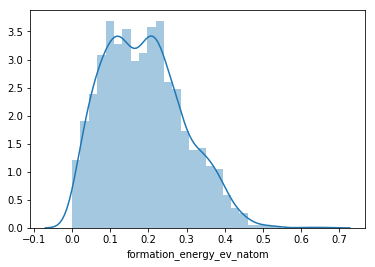

In [7]:
ax = sns.distplot(train_labels)

In [8]:
## Standardizing numeric features
numeric_features = features.loc[:,['number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

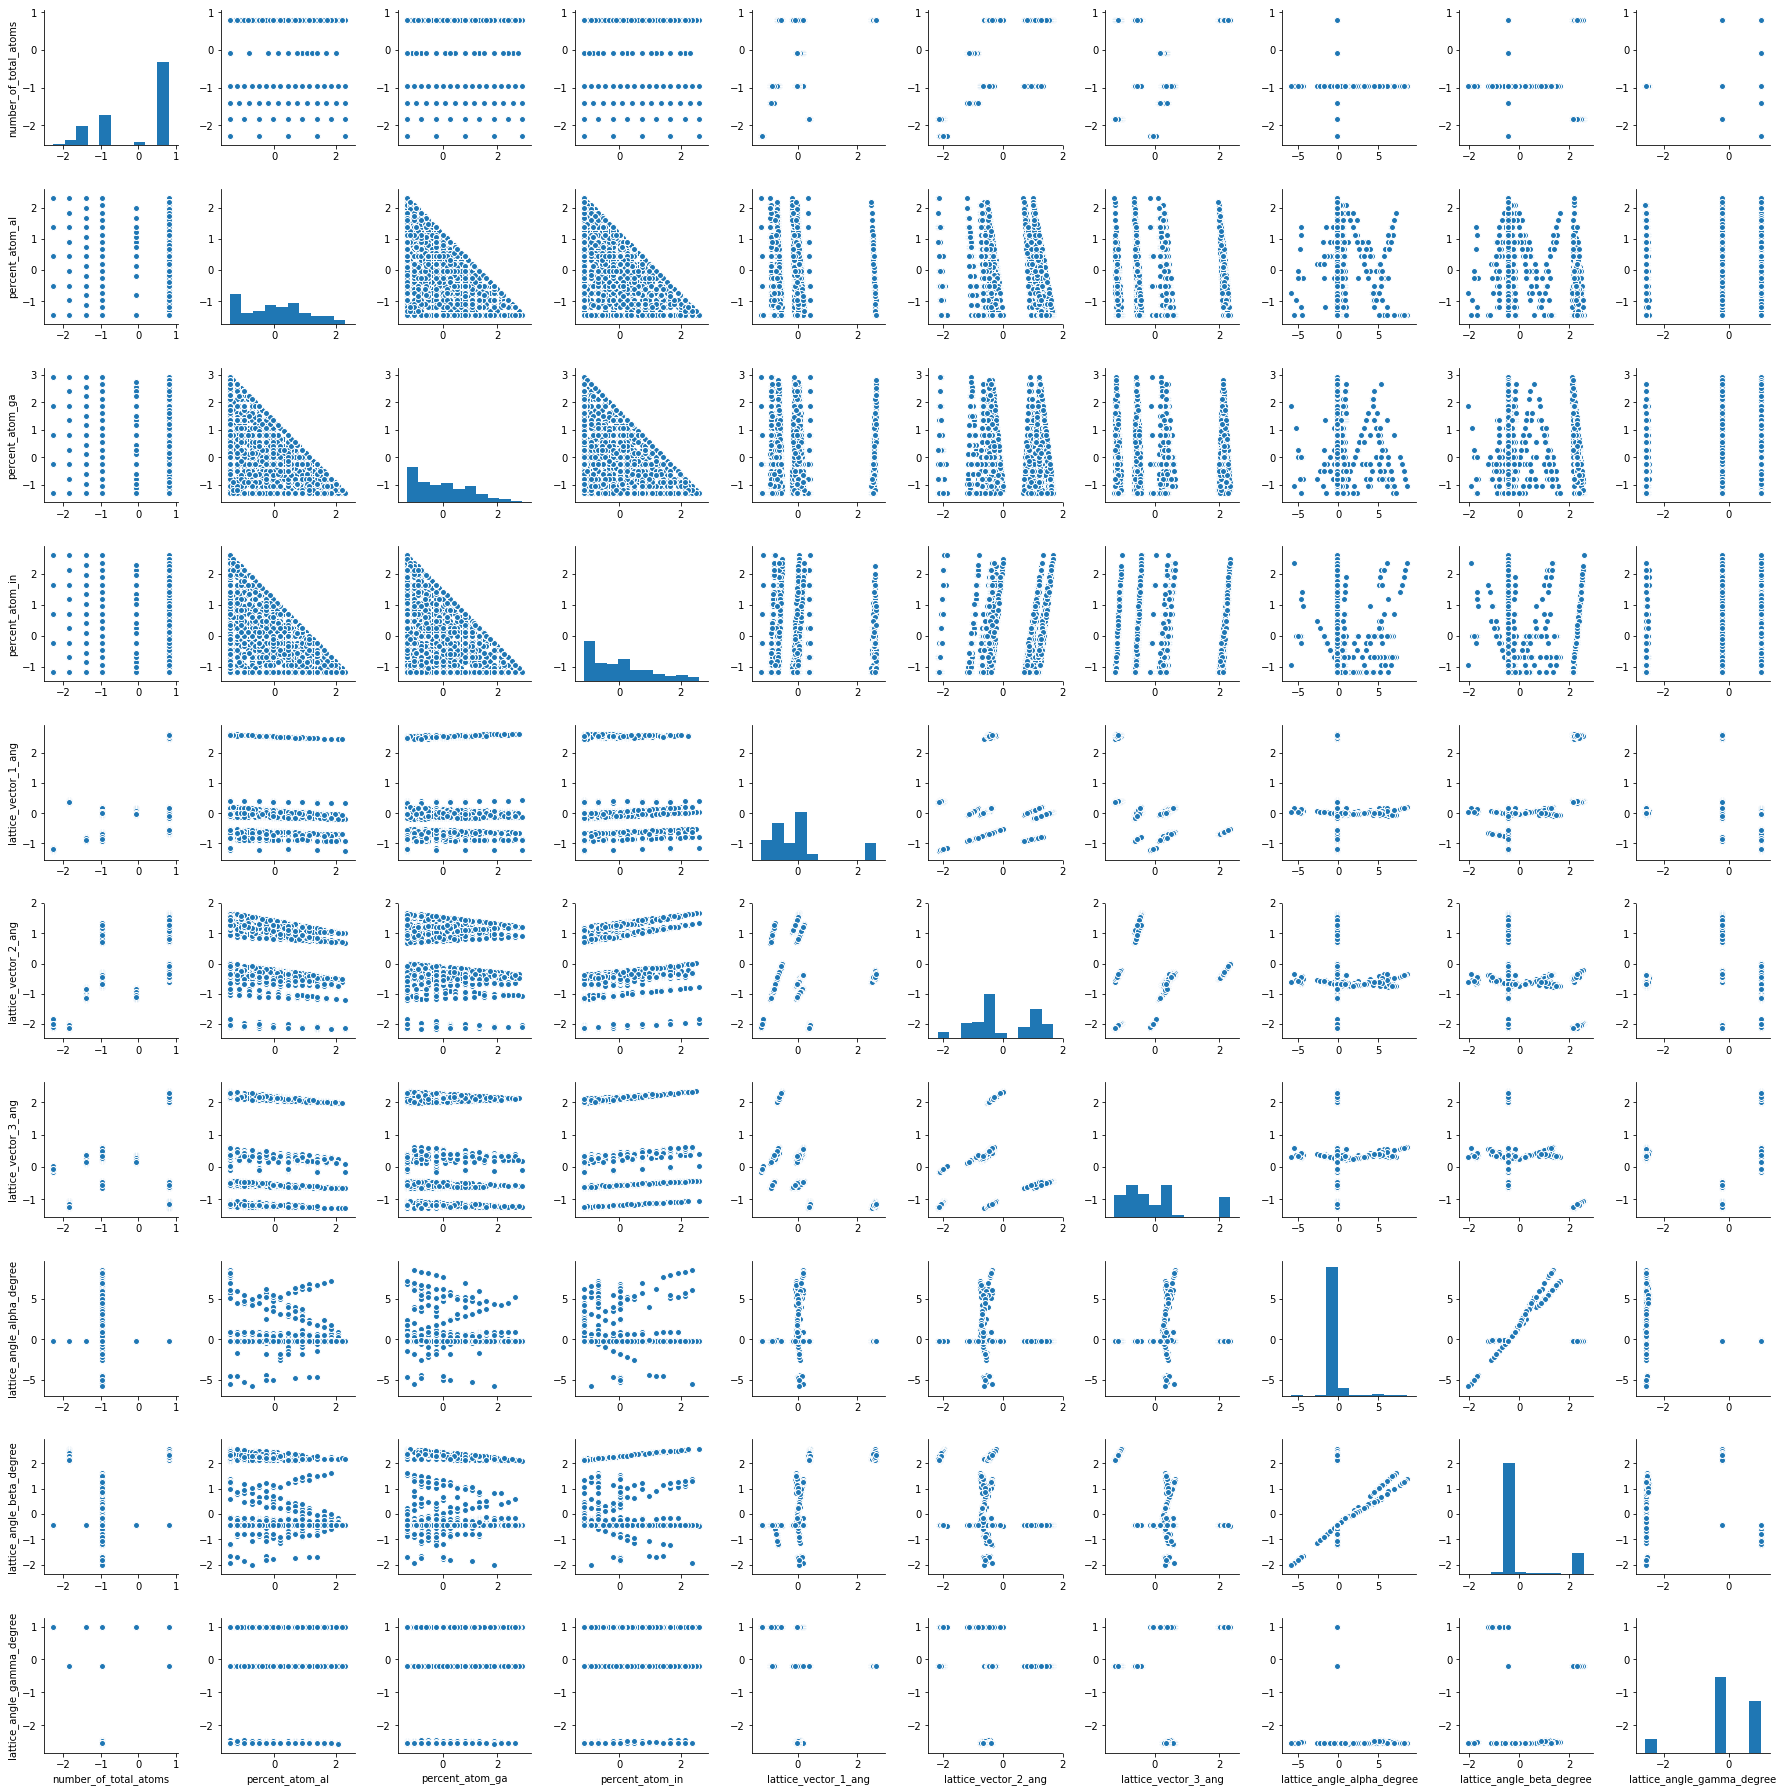

In [9]:
ax = sns.pairplot(numeric_features_standardized)

In [10]:
# # Getting Dummies from Condition1 and Condition2
# conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
# dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
#                        index=features.index, columns=conditions)
# for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
#     dummies.ix[i, cond] = 1
# features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
# features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# # Getting Dummies from Exterior1st and Exterior2nd
# exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
# dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
#                        index=features.index, columns=exteriors)
# for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
#     dummies.ix[i, ext] = 1
# features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
# features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [11]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [12]:
### Splitting features
train_features = features.loc['train'].drop('id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('id', axis=1).select_dtypes(include=[np.number]).values

In [13]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [14]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [38]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.1276583541251365
RMSLE: 0.05975253078834906
Test
R2: -0.054125417532489895
RMSLE: 0.059581322337162616


In [39]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.53 (+/- 0.04)


In [40]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=10000, learning_rate=0.01, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.8952702522905218
RMSLE: 0.025281257243260212
Test
R2: 0.8616896037938101
RMSLE: 0.028469899802895868


In [18]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.06)


In [19]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)

In [31]:
## Getting our SalePrice estimation
Final_labels = (GB_model.predict(test_features) + ENST_model.predict(test_features_st)) / 2
Final_labels[Final_labels < 0] = 0

In [32]:
## Saving to CSV
pd.DataFrame({'id': test.id, 'formation_energy_ev_natom': Final_labels}).to_csv('label1.csv', index = False)    